# Project description
Beta Bank customers are leaving: little by little, chipping away every month. The bankers figured out it’s cheaper to save the existing customers rather than to attract new ones.
We need to predict whether a customer will leave the bank soon. You have the data on clients’ past behavior and termination of contracts with the bank.

**Tasks:**
- Build a model with the maximum possible F1 score. Threshold: 0.59 on test set
- Measure the AUC-ROC metric
- Compare AUC-ROC with the F1.



# TOC
- [Project description](#Project-description)
- [TOC](#TOC)
- [1. Data and lib import](#1.-Data-and-lib-import)
- [2. Data inspection](#2.-Data-inspection)
- [3. Data preprocessing](#3.-Data-preprocessing)
    * [3.1. Renaming columns and dropping uneccessary information](#3.1.-Renaming-columns-and-dropping-uneccessary-information)
    * [3.1. Filling NA values](#3.1.-Filling-NA-values)
    * [3.2. Adjusting datatypes](#3.2.-Adjusting-datatypes)
    * [3.3. Outliers](#3.3.-Outliers)
    * [3.4. Feature and target selection with feature scaling](#3.4.-Feature-and-target-selection-with-feature-scaling)        
    * [3.5. One hot encoding](#3.5.-One-hot-encoding)
    * [3.6. Split dataset](#3.6.-Split-dataset)
- [4. Model development](#4.-Model-development)
    * [4.1. Benchmarking: Imbalanced features](#4.1.-Benchmarking:-Imbalanced-features)
        + [4.1.1. Developing functions for benchmarking](#4.1.1.-Developing-functions-for-benchmarking)
        + [4.1.2. Model selection: Crossvalidation](#4.1.2.-Model-selection:-Crossvalidation)
    * [4.2. Model development balanced features](#4.2.-Model-development-balanced-features)
        + [4.2.2. Upsampling](#4.2.2.-Upsampling)
        + [4.2.3. Downsampling](#4.2.3.-Downsampling)
        + [4.2.3. Class weight adjustments](#4.2.3.-Class-weight-adjustments)
        + [4.2.4. Standard model comparison](#4.2.4.-Standard-model-comparison)
    * [4.2. Training hyperparameter](#4.2.-Training-hyperparameter)
        + [4.2.1. Logistic regression](#4.2.1.-Logistic-regression)
            - [4.2.1.1. Randomized grid search](#4.2.1.1.-Randomized-grid-search)
            - [4.2.1.2. Grid search with cv](#4.2.1.2.-Grid-search-with-cv)
            - [4.2.1.3. Threshold adjustment](#4.2.1.3.-Threshold-adjustment)
        + [4.2.2. Random Forest](#4.2.2.-Random-Forest)
            - [4.2.2.1. Randomized grid search](#4.2.2.1.-Randomized-grid-search)
            - [4.2.2.2. Grid search](#4.2.2.2.-Grid-search)
- [5. Conclution](#5.-Conclution)

In [1]:
# Activate autocomplete
%config Completer.use_jedi = False

In [2]:
# Use the button below to toggle warnings
from IPython.display import HTML
HTML('''<script>
var code_show_err = false; 
var code_toggle_err = function() {
 var stderrNodes = document.querySelectorAll('[data-mime-type="application/vnd.jupyter.stderr"]')
 var stderr = Array.from(stderrNodes)
 if (code_show_err){
     stderr.forEach(ele => ele.style.display = 'block');
 } else {
     stderr.forEach(ele => ele.style.display = 'none');
 }
 code_show_err = !code_show_err
} 
document.addEventListener('DOMContentLoaded', code_toggle_err);
</script>
To toggle on/off output_stderr, click <a onclick="javascript:code_toggle_err()">here</a>.''')

# 1. Data and lib import



In [3]:
# Standard libs
import warnings
from collections import OrderedDict
from os.path import isfile

# Data manipulating and plotting imports
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
from scipy import stats as st
%matplotlib inline

# ML import


warnings.filterwarnings("ignore")
import joblib
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score 
from sklearn.metrics import roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
    
# Constants
RANDOM_STATE = 42

try:
    df = pd.read_csv('./datasets/Churn.csv')
except:
    df = pd.read_csv('https://code.s3.yandex.net/datasets/Churn.csv')

display(df.head(2))

C:\Users\JonathanLang\.conda\envs\practicum\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\JonathanLang\.conda\envs\practicum\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
C:\Users\JonathanLang\.conda\envs\practicum\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  stacklevel=1)


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0


# 2. Data inspection
**Data description:**  
> **Features:**
> - RowNumber — data string index  
> - CustomerId — unique customer identifier  
> - Surname — surname  
> - CreditScore — credit score  
> - Geography — country of residence  
> - Gender — gender  
> - Age — age  
> - Tenure — period of maturation for a customer’s fixed deposit (years)  
> - Balance — account balance  
> - NumOfProducts — number of banking products used by the customer  
> - HasCrCard — customer has a credit card  
> - IsActiveMember — customer’s activeness  
> - EstimatedSalary — estimated salary  

> **Target:**  
> - Exited — сustomer has left  



In [4]:
display(df.head(5))
print(df.info())

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB
None


> **Observations:**  
> - Dataframe which contains 10000 entries
> - Tenture misses values (909 Values)
> - datatypes of Tenture, balance can be converted to int
> - Rownumber can be dropped in total because it does not provide addtional information
> - 0 in Balance collumn must be investigated, if missing value or not
> - Geography and Gender can be categorized or OHE
> - Cathegorize Credit score, salery and balance to transfer continous variable to categorical

In [5]:
# Exclude RowNumber and CustomerId becuse they do not matter in this step
display(df.drop(['RowNumber', 'CustomerId'], axis=1).describe())
print('> Num of balance equal zero:', (df.Balance== 0.0).sum())

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.000000,10000.000000,9091.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,650.528800,38.921800,4.997690,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,96.653299,10.487806,2.894723,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,584.000000,32.000000,2.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


> Num of balance equal zero: 3617


> **Observations:**  
> - 36% of the Balance entries are 0, further investigation needed, talk with data engineer about data aggregation. But for this project in the first hand, they are taken as real, valid data. If the Model quality is low, we might need to fill them based on 
> - credit score, age, tenture, balance and numofproducts contain outliers
> - only 20.37% of the targets Exited -> Imbalanced

# 3. Data preprocessing
> In the data preprocessing of the data the following steps need to be carried out:  
> **EDA:**     
> - Fill missing values  
> - Investigate outliers and take measures if neccessary
> - Adjusting datatypes

> **Machine learning**
> - Feature Scaling  
> - Investigate balance of classes:  
> - Sampling sizes (over/undersampled)  
> - Splitting dataset


## 3.1. Renaming columns and dropping uneccessary information
> - To ease further processing, more intuitive column names have been choosen
> - RowNumber has been dropped because it does not provide any information.
> - Surname has been dropped because the identification is aready possible via the id

In [6]:
# dropping RowNumber
df.drop(['RowNumber', 'Surname', 'CustomerId'], inplace=True, axis=1)

# replace column names
col_names = ['credit_score', 'country', 'sex', 'age', 'tenure', 
             'balance', 'products', 'has_card', 'active',
             'estimated_salary', 'exited']
df.columns = col_names

## 3.1. Filling NA values
> Because around 9% of values are missing for the tenure duration, it is too much to drop. therefore the strategy for filling has been determinated and executed.

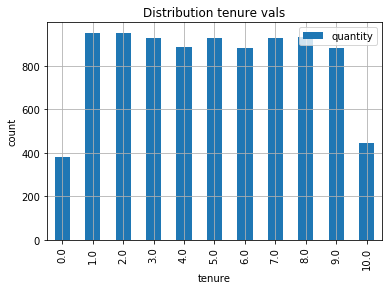

In [7]:
# Plotting distribution of tenure
ax = df.groupby('tenure').agg(quantity = ('tenure', 'count')) \
       .plot(kind='bar')
ax.set_title('Distribution tenure vals')
ax.set_ylabel('count')
ax.grid()

> No obvious conspicuousness in distribution

In [8]:
# Getting an overview over NAN values
print('Overview NaN values')
display(df[df['tenure'].isna()==True].describe())
print('Overview total')
display(df.describe())

Overview NaN values


,credit_score,age,tenure,balance,products,has_card,active,estimated_salary,exited
count,909.000000,909.000000,0.0,909.000000,909.000000,909.000000,909.000000,909.000000,909.000000
mean,648.451045,38.647965,NaN,76117.341474,1.530253,0.710671,0.510451,99180.389373,0.201320
std,99.079381,9.785438,NaN,63105.690715,0.588452,0.453701,0.500166,56378.063765,0.401207
min,359.000000,18.000000,NaN,0.000000,1.000000,0.000000,0.000000,106.670000,0.000000
25%,580.000000,32.000000,NaN,0.000000,1.000000,0.000000,0.000000,49872.330000,0.000000
50%,647.000000,37.000000,NaN,96674.550000,1.000000,1.000000,1.000000,99444.020000,0.000000
75%,718.000000,43.000000,NaN,128554.980000,2.000000,1.000000,1.000000,145759.700000,0.000000
max,850.000000,92.000000,NaN,206663.750000,4.000000,1.000000,1.000000,199390.450000,1.000000


Overview total


,credit_score,age,tenure,balance,products,has_card,active,estimated_salary,exited
count,10000.000000,10000.000000,9091.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,650.528800,38.921800,4.997690,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,96.653299,10.487806,2.894723,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,584.000000,32.000000,2.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


> Checking distributions of numerical values in order to check distibutions, visually and with ttest.    
> Hypothesis for ttest:  
> H0: The Variances can be considred the same  
> H1: The variances can not be considered the same  
> Significance niveau: 0.05

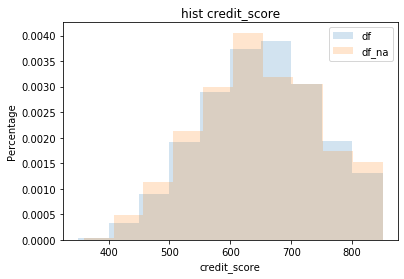

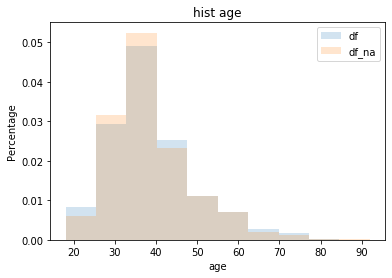

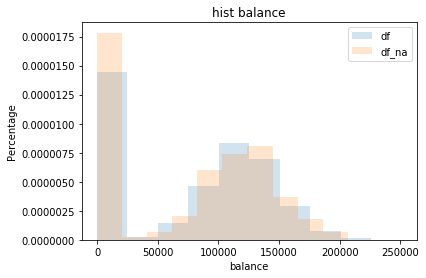

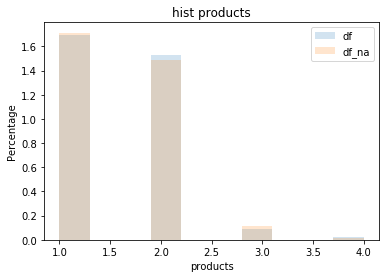

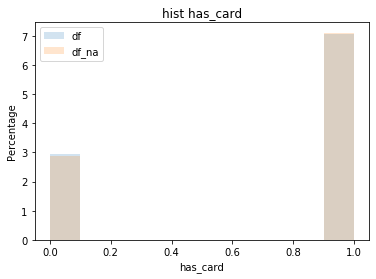

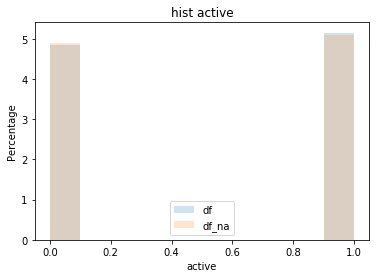

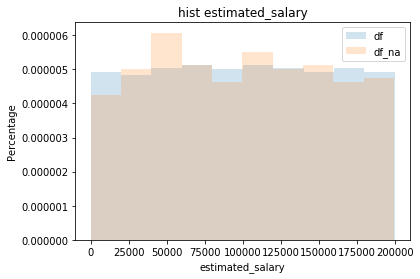

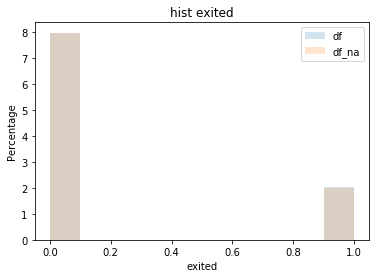

In [9]:
df_nan = df.loc[df['tenure'].isna()==True]
cols = ['credit_score', 'age', 'balance', 'products', 'has_card',
        'active', 'estimated_salary','exited']

for idx, col in enumerate(cols):
    for sub_df in (df, df_nan): 
        ax = sub_df[col].plot(kind='hist', alpha=0.2, density=True)
    ax.set_title('hist' + ' ' + cols[idx])
    ax.legend(('df', 'df_na'))
    ax.set_xlabel(col)
    ax.set_ylabel('Percentage')
    plt.show()

> No conspicuousness, distributions can be considered the same for all checked features because pval > alpha

In [10]:
# Checking for linear correlations to fill in
df.corr()

,credit_score,age,tenure,balance,products,has_card,active,estimated_salary,exited
credit_score,1.000000,-0.003965,-0.000062,0.006268,0.012238,-0.005458,0.025651,-0.001384,-0.027094
age,-0.003965,1.000000,-0.013134,0.028308,-0.030680,-0.011721,0.085472,-0.007201,0.285323
tenure,-0.000062,-0.013134,1.000000,-0.007911,0.011979,0.027232,-0.032178,0.010520,-0.016761
balance,0.006268,0.028308,-0.007911,1.000000,-0.304180,-0.014858,-0.010084,0.012797,0.118533
products,0.012238,-0.030680,0.011979,-0.304180,1.000000,0.003183,0.009612,0.014204,-0.047820
has_card,-0.005458,-0.011721,0.027232,-0.014858,0.003183,1.000000,-0.011866,-0.009933,-0.007138
active,0.025651,0.085472,-0.032178,-0.010084,0.009612,-0.011866,1.000000,-0.011421,-0.156128
estimated_salary,-0.001384,-0.007201,0.010520,0.012797,0.014204,-0.009933,-0.011421,1.000000,0.012097
exited,-0.027094,0.285323,-0.016761,0.118533,-0.047820,-0.007138,-0.156128,0.012097,1.000000


> **Observations:**
> - There are no linear correlationsof tenure  
> - There is a low correlation between age and the target

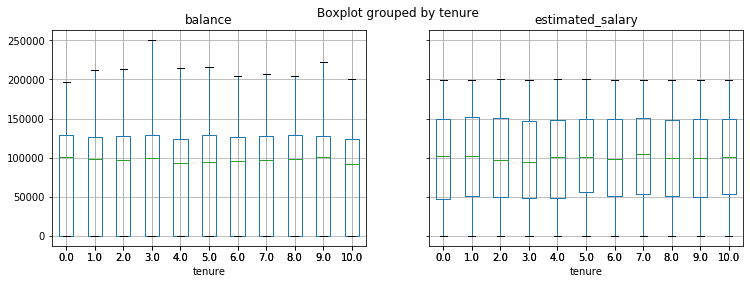

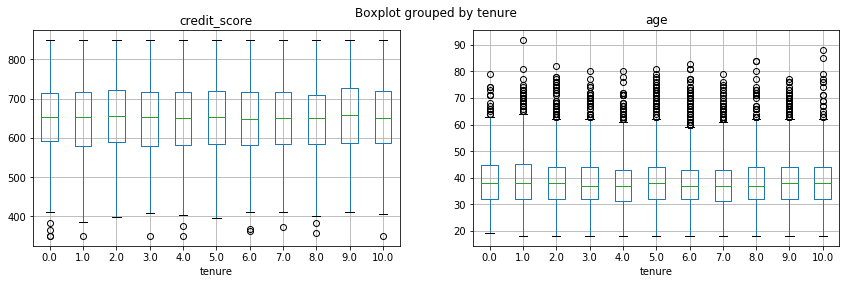

In [11]:
# Single boxplot grouped by col2 multiple (for cathegorical)
df.boxplot(by='tenure', column=['balance', 'estimated_salary'], figsize=(12,4));
plt.show()

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 4))
plt.subplots_adjust(hspace=0.3)
for idx, col in enumerate(['credit_score', 'age']):
    df.boxplot(by='tenure', column=col, ax=ax[idx])
    

> **Observations:**
> - tenture correlates with balance and the age. The values will be filled in based on those 2 factors.
> - Also credit score and age contain outiers -> But those are valid values so they will be kept.
> - *If there is time, train also withou outliers*

In [12]:
df['tenure'].fillna(
    df.groupby(['balance', 'age'])['tenure'].transform(np.mean),
    inplace=True
)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   credit_score      10000 non-null  int64  
 1   country           10000 non-null  object 
 2   sex               10000 non-null  object 
 3   age               10000 non-null  int64  
 4   tenure            9425 non-null   float64
 5   balance           10000 non-null  float64
 6   products          10000 non-null  int64  
 7   has_card          10000 non-null  int64  
 8   active            10000 non-null  int64  
 9   estimated_salary  10000 non-null  float64
 10  exited            10000 non-null  int64  
dtypes: float64(3), int64(6), object(2)
memory usage: 859.5+ KB


> There are still 575 missing values. They will be filled with the mean related to age

In [14]:
df['tenure'].fillna(
    df.groupby(['age'])['tenure'].transform(np.mean),
    inplace=True
)

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   credit_score      10000 non-null  int64  
 1   country           10000 non-null  object 
 2   sex               10000 non-null  object 
 3   age               10000 non-null  int64  
 4   tenure            10000 non-null  float64
 5   balance           10000 non-null  float64
 6   products          10000 non-null  int64  
 7   has_card          10000 non-null  int64  
 8   active            10000 non-null  int64  
 9   estimated_salary  10000 non-null  float64
 10  exited            10000 non-null  int64  
dtypes: float64(3), int64(6), object(2)
memory usage: 859.5+ KB


> All missing data has been filled

## 3.2. Adjusting datatypes
> In this step all floats and int64s have been converted to int32 to speed up later training

In [16]:
# Converting all float and int64 to int32 to speed up later training
to_int = ['credit_score', 'age', 'tenure', 'exited',
       'balance', 'products', 'has_card', 'active', 'estimated_salary']

for col in to_int:
    df[col] = df[col].astype(int)

## 3.3. Outliers
> In this chapter outliers have been determinated.

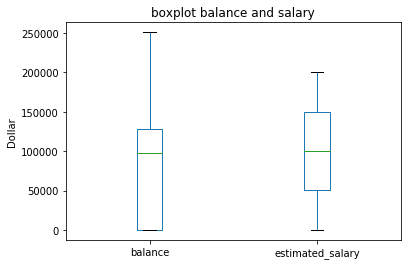

In [17]:
# Plotiting together due to same range
ax = df[['balance', 'estimated_salary']].plot(kind='box');
ax.set_title('boxplot balance and salary')
ax.set_ylabel('Dollar')
plt.show()

> **Observations:**
> - balance is strong shifted (due to the 0 values)
> - In this setup there are no outliers
> - 0 can be considered as a true value here, if people have multiple bank accounts, some might be total empty. But here is some talk with the data engineer needed to verify

> Num of balance equal zero: 3617


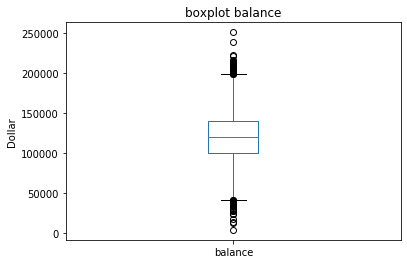

In [18]:
# Checking without 0 accounts
print('> Num of balance equal zero:', (df.balance== 0.0).sum())
ax = df.query('balance > 0')['balance'].plot(kind='box');
ax.set_title('boxplot balance')
ax.set_ylabel('Dollar')
plt.show()

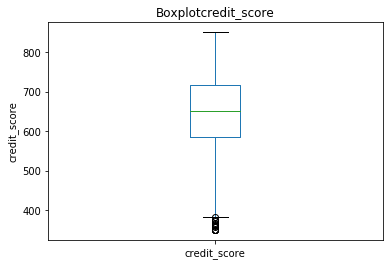

upper whisker: 919.0
lower whisker: 383.0


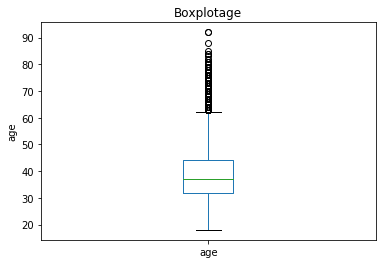

upper whisker: 62.0
lower whisker: 14.0


In [19]:
check_out = ['credit_score', 'age']
for idx, col in enumerate(check_out):
    ax = df[col].plot(kind='box')
    ax.set_ylabel(check_out[idx])
    ax.set_title('Boxplot' + check_out[idx])
    ax.grid
    plt.show()
    iqr = df[col].quantile(.75) - df[col].quantile(.25)
    low = df[col].quantile(.25) - iqr*1.5
    up = df[col].quantile(.75) + iqr*1.5
    print(f'upper whisker: {up}\nlower whisker: {low}')

> **Observations:**
> - Both age and credit score contain outliers
> - Outliers seem to be valid entries, so they have been keept. 
> - In case of low model quality, the outliers can be removed in order to try to improve the model quality by doing so

## 3.4. Feature and target selection with feature scaling
> The first step of feature and target selection has already been carried out in chapter 2 and 3.1.:  
> - In chapter 2 the exit column has been identified as target where as the rest of the columns have been defined as fearures
> - In chapter 3.1. the collumns RowNumber, Surname and CustomerId have been dropped because the do not add any usefull information related to the target (Surname, customierId) or the dataframe itself (RowNumber equals index+1)

> To improve the expected accuracy of the machine learning model, the numerical data has been scaled. (Even if decision trees might not be to be too influcenced by unscaled data but linear regression for example is.) Those columns are credit_score, balance, age and estimated_salery

In [20]:
# Selecting features and target
print('target:', df.columns[-1])
print('features:', list(df.columns[:-1]))

target: exited
features: ['credit_score', 'country', 'sex', 'age', 'tenure', 'balance', 'products', 'has_card', 'active', 'estimated_salary']


In [21]:
# aggregating columns to scale:
to_scale = ['credit_score', 'tenure', 'balance', 'products', 'age', 'estimated_salary']

# Instance, fit and transform scaler
sscaler= StandardScaler()
sscaler.fit(df[to_scale])
features_scaled = sscaler.transform(df[to_scale])

In [22]:
# Merge scaled data with rest of df
df_scaled = df.copy()
for idx, col in enumerate(to_scale):
    df_scaled[col] = features_scaled[:, idx]

## 3.5. One hot encoding
> Decison trees and linear regression are not able to deal with cathegorical values as long as they are strings. Thus they need to be encoded. This applies for the columns: country and sex  
> To not give the algorithm the impression that one conuntry or sex is more important than the other by a higher value (same applies for sex) those features will be one hot encoded and not ordinal encoded. (With the dropfirst argznebt dropfirst = True to avoid the dummy trap)

In [23]:
df_scaled_ohe = pd.get_dummies(df_scaled, drop_first=True)
df_scaled_ohe.head(5)

,credit_score,age,tenure,balance,products,has_card,active,estimated_salary,exited,country_Germany,country_Spain,sex_Male
0,-0.326221,0.293517,-1.067519,-1.225847,-0.911583,1,1,0.021880,1,0,0,0
1,-0.440036,0.198164,-1.428789,0.117342,-0.911583,0,1,0.216532,0,0,1,0
2,-1.536794,0.293517,1.100105,1.333050,2.527057,1,0,0.240686,1,0,0,0
3,0.501521,0.007457,-1.428789,-1.225847,0.807737,0,0,-0.108920,0,0,0,0
4,2.063884,0.388871,-1.067519,0.785723,-0.911583,1,1,-0.365269,0,0,1,0


## 3.6. Split dataset
> Splitting the dataset into test and train set. This split is performed because on the reference model the hyperparameters are not tuned and for the proper model cross validation is used. Thus no overfitting during hyperparameter tuning to the evaluation set takes places 

In [24]:
# Definition of features and targets
features = df_scaled_ohe.drop(['exited'], axis=1)
target = df_scaled_ohe['exited']

In [25]:
# Split For unbalanced model
X_train, X_test, y_train, y_test = train_test_split(features,
                                                   target,
                                                    train_size=0.8,
                                                    random_state = RANDOM_STATE
                                                   )

In [26]:
# For up and downsampling
df_train, df_test = train_test_split(df_scaled_ohe,
                                    train_size=0.8,
                                    random_state = RANDOM_STATE
                                    )

> **Summary Preprocessing**:
> Within the preprocessing the following steps have been carried out:
> - Dropping unnecessary collumns
> - Renaming the collums to ease working with the df
> - Filling in missing values
> - Adjusting the datatypes
> - Investigate ourliers and their nature
> - Identifying features and targets as well as splitting the dataset
> - One hot encoding for cathegorical features

# 4. Model development
Examine the balance of classes. Train the model without taking into account the imbalance. Briefly describe your findings.
Improve the quality of the model. Make sure you use at least two approaches to fixing class imbalance. Use the training set to pick the best parameters. Train different models on training and validation sets. Find the best one. Briefly describe your findings.
Perform the final testing.

- Build a model with the maximum possible F1 score. Threshold: 0.59 on test set
- Measure the AUC-ROC metric
- Compare AUC-ROC with the F1.

Accuracy is used when the True Positives and True negatives are more important while F1-score is used when the False Negatives and False Positives are crucial
Accuracy can be used when the class distribution is similar while F1-score is a better metric when there are imbalanced classes as in the above case.

## 4.1. Benchmarking: Imbalanced features
> In the first step a machine learning model with the imbalanced features has been made. Therefore the prefered algorithm for this task has been determined via crossvalidation.   (80% class0 to 20% class1)
> In the folling step models with the tested algorithms have been built and evaluated.

In [27]:
print('percentage of class 1 in targets: {:.2%}'.format(target.mean()))

percentage of class 1 in targets: 20.37%


### 4.1.1. Developing functions for benchmarking
> In this chapter the crucial functions for benchmarking have been implemented. They can be exported to a python script in production

In [28]:
# Definition of the crucial functions

def disp_characteristics_subplots(characteristics, metrics=('accuracy', )):
    '''Characteristics:[dict] k[string]: [list of 10 floats]
    metrics[iterable]: same metrics then for calculating characteristics'''
    for met in metrics:
        tmp_data = {k: v for k,v in characteristics.items() if met in k}
        n_cols = len(tmp_data) + 1 
        fig, ax = plt.subplots(nrows=1, ncols=n_cols, figsize=(14, 4))
        
        for idx, (k, v) in enumerate(tmp_data.items()):
            ax[idx].bar([cv for cv in range(1,11)], v);
            ax[idx].grid(True)
            ax[idx].set_xlabel('Model of CV iteration')
            ax[idx].set_ylabel(met + ' ' + 'score [%]')
            title = '10 fold cv' + ' ' + k
            ax[idx].set_title(title)
            ax[idx].plot([0, 11], [np.mean(v)] * 2,
                         color='r', label='mean')
            ax[idx].legend()
            
        for k, v in tmp_data.items():
            ax[len(tmp_data)].bar([cv for cv in range(1,11)], v, label=k, alpha=0.4);
            ax[len(tmp_data)].set_xlabel('Model of CV iteration')
            ax[len(tmp_data)].set_ylabel(met + ' ' + 'score [%]')
        title = '10 fold cv scoring:' + ' ' + met
        plt.title(title)
        plt.legend()
                
        plt.show()

        
def det_characteristic(models, X, y, metrics=('accuracy', )):
    '''This function carries out the crossvalidation for the given models
    with the given evaluation matrics
    arguments:
        models[dict]: key:modelname, value:name
        metrics[iterable]: evaluation metricx
    returns
        characteristics[dict]: contain the modelnames with the characteristics
        cv_models[dict]: contains the 10 subaccuracity during cross validation per model
    '''
    characteristics = OrderedDict()
    cv_models = OrderedDict()
    for met in metrics:
        for name, model in models.items():
            mod_cv = cross_val_score(model,
                                    X,
                                    y,
                                    cv=10,
                                    scoring=met)
            characteristical = [np.std(mod_cv),
                                np.mean(mod_cv),
                                min(mod_cv),
                                max(mod_cv)]
            characteristics.update({
                name + '_' + met: characteristical
            })    
            cv_models.update({
                name + '_' + met: mod_cv
            })
    return (characteristics, cv_models)

def create_table(characteristics):
    '''Creates characteristical data from dict to pd dataframe'''
    characteristics_df = pd.DataFrame(characteristics.values(),
                                     index=characteristics.keys(),
                                     columns=('std', 'mean', 'min', 'max'))
    return characteristics_df

### 4.1.2. Model selection: Crossvalidation
> In this step a prediction for different algorithms is carried out, to predict which one will perform best. The evaluation has been carried out with the previous implemented functions.

In [29]:
# Instancing the machine learning algorithms to check
rfc_ref = RandomForestClassifier(random_state=RANDOM_STATE)
logreg_ref = LogisticRegression(random_state=RANDOM_STATE)
models_ref = {'rfc': rfc_ref, 'logreg': logreg_ref}
# 
# Aggregating the evaluation metrics to compare
comp_metrics = ('f1', 'recall', 'precision', 'accuracy')

# get the characteristc data
with warnings.catch_warnings() as w:
    warnings.filterwarnings("ignore")
    char_benchmark = det_characteristic(models_ref, X_train, y_train, comp_metrics)
    
display(create_table(char_benchmark[0]))

,std,mean,min,max
rfc_f1,0.023722,0.576661,0.541833,0.621908
logreg_f1,0.058856,0.313652,0.184466,0.379747
rfc_recall,0.033661,0.465318,0.412121,0.533333
logreg_recall,0.045272,0.213422,0.115854,0.272727
rfc_precision,0.045598,0.764024,0.675214,0.829787
logreg_precision,0.079488,0.600781,0.452381,0.732143
rfc_accuracy,0.007530,0.859875,0.845000,0.872500
logreg_accuracy,0.011083,0.809625,0.790000,0.826250


In [30]:
# Training without crossvalidation for later benchmarking
logreg_standard_imbalanced = LogisticRegression(random_state=RANDOM_STATE)
rfc_standard_imbalanced = RandomForestClassifier(random_state=RANDOM_STATE)
for submodel in (rfc_standard_imbalanced, logreg_standard_imbalanced): 
    submodel.fit(X_train, y_train)
logreg_standard_imbalanced_pred = logreg_standard_imbalanced.predict(X_test)
rfc_standard_imbalanced_pred = rfc_standard_imbalanced.predict(X_test)
logreg_standard_imbalanced_f1 = f1_score(y_test, logreg_standard_imbalanced_pred)
rfc_standard_imbalanced_f1 = f1_score(y_test, rfc_standard_imbalanced_pred)

> **Observations**
> - for each metrics the mean and max is higer for the random forest compared to the logistical regession.
> - beside the recall, the standard dervation of the linreg is higher than the one of the random forest

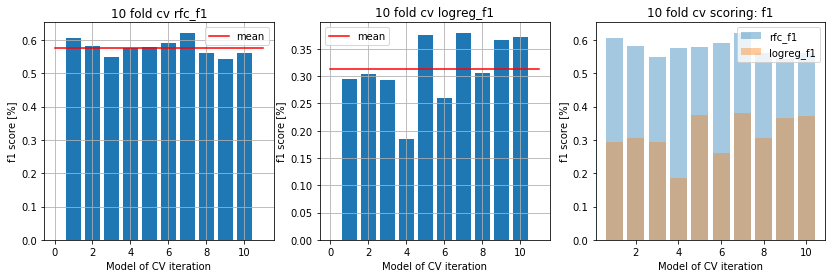

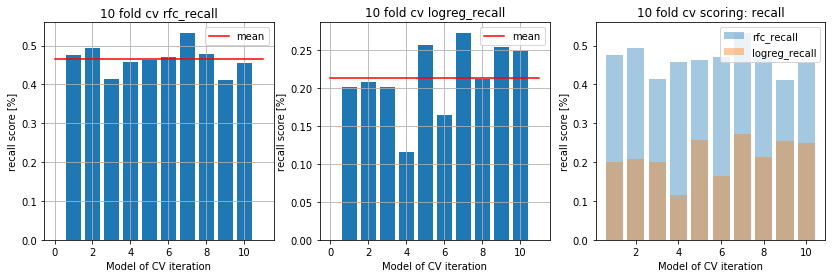

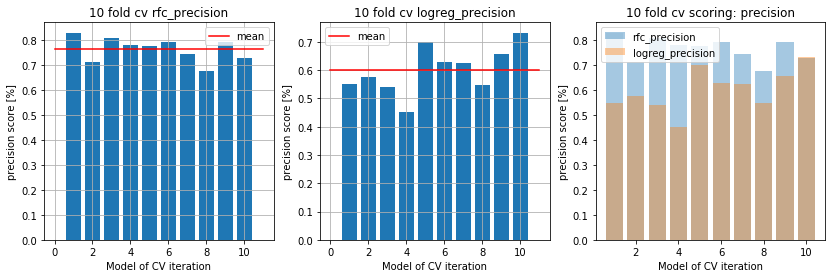

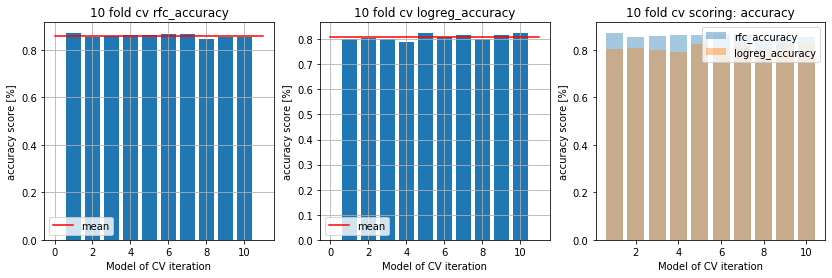

In [31]:
disp_characteristics_subplots(char_benchmark[1], ('f1', 'recall', 'precision', 'accuracy'))

> **Observations:**
> - In all evaluation metrics, but espectially in the recal and consequently the f1 score, the decision trees perform much better than linear regression. 
> - \-\> The perforamnce and stability (for training data) of a standard model of random forests is expected to be higher for this task without balancing classes, hyperparameter tuning and threshold adjustments

## 4.2. Model development balanced features
> In this step the imbalance of the classes (4:1, which is shown below) has been minimized with different methods for the train set.  
> The test set remained like it was to test the model accuracy for deployment.
> The outcome of those methods will be compared.  
> Finally the best method will be selected and the model will be trained on the adjuested data (including tuning hyperparameter as well as the threshold adjustment for the logistic regression.

> The 3 different versions of tackeling the imbalance of the classes substitute of:
> - Upsampling 
> - Downsampling
> - Class weight adjustments

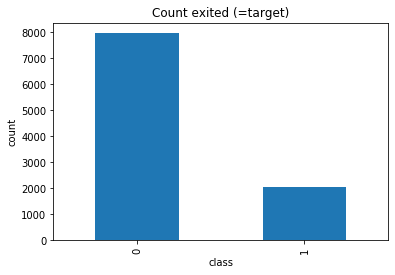

In [32]:
# Investigating imbalance in the total dataset
# Slicing df in class 0 and class 1
df_c0 = df_scaled_ohe[df_scaled_ohe['exited']==0]
df_c1 = df_scaled_ohe[df_scaled_ohe['exited']==1]

# Get count of each class
cnt_c0, cnt_c1 = df.exited.value_counts()

# Plott class relations
ax = df.exited.value_counts().plot(kind='bar', title='Count exited (=target)');
ax.set_xlabel('class')
ax.set_ylabel('count')
plt.show()

### 4.2.2. Upsampling
> In this step the samples of the underrepresented class will be upsampled for the test data by using the pandas method sample and the replace=True parameter. Alternatively resample from sklearn.utils could be used.

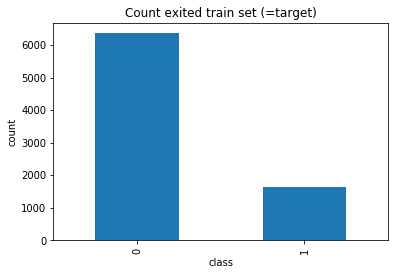

In [33]:
# Investigating imbalance for train set
df_c0_train = df_train[df_train['exited']==0]
df_c1_train = df_train[df_train['exited']==1]

# Get count of each class
cnt_c0_train, cnt_c1_train = df_train.exited.value_counts()

# Plott class relations
ax = df_train.exited.value_counts().plot(kind='bar', title='Count exited train set (=target)');
ax.set_xlabel('class')
ax.set_ylabel('count')
plt.show()

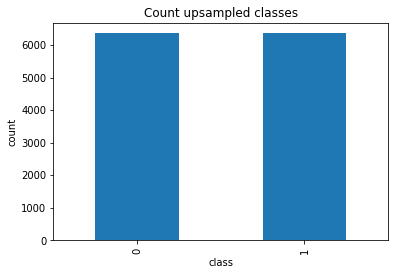

In [34]:
# Upsample underrepresened class
df_c1_ups = df_c1_train.sample(cnt_c0_train, random_state=RANDOM_STATE, replace=True)

# Concat data of upsampled class 1 and class 0
df_ups = shuffle(pd.concat([df_c1_ups, df_c0_train]))

# Plott result
ax = df_ups.exited.value_counts().plot(kind='bar', title='Count upsampled classes');
ax.set_xlabel('class')
ax.set_ylabel('count')
plt.show()

> Both classes contain now around 6200 samples

In [35]:
# Get X,y from upsampled df
X_train_us = df_ups.drop('exited', axis=1)
y_train_us = df_ups['exited']

In [36]:
# Instancing the machine learning algorithms to check
rfc_ups = RandomForestClassifier(random_state=RANDOM_STATE)
logreg_ups = LogisticRegression(random_state=RANDOM_STATE)
models_ups = {'rfc': rfc_ups, 'logreg': logreg_ups}

# Aggregating the evaluation metrics to compare
comp_metrics = ('f1', 'recall', 'precision', 'accuracy')

# get the characteristc data
with warnings.catch_warnings() as w:
    warnings.filterwarnings("ignore")
    char_benchmark_up = det_characteristic(models_ups, X_train_us, 
                                          y_train_us, comp_metrics)

display(create_table(char_benchmark_up[0]))

,std,mean,min,max
rfc_f1,0.003441,0.959161,0.954268,0.964724
logreg_f1,0.012770,0.699704,0.682072,0.720387
rfc_recall,0.003292,0.984580,0.977953,0.988994
logreg_recall,0.014294,0.693520,0.672441,0.715409
rfc_precision,0.005747,0.935043,0.926036,0.942857
logreg_precision,0.016324,0.706202,0.688854,0.737624
rfc_accuracy,0.003623,0.958071,0.952793,0.963808
logreg_accuracy,0.013498,0.702331,0.686321,0.726987


In [37]:
# F1 Score for benchmarking without cv
rfc_standard_us = RandomForestClassifier(random_state=RANDOM_STATE)
logreg_standard_us = LogisticRegression(random_state=RANDOM_STATE)

for submodel in (rfc_standard_us, logreg_standard_us):
    submodel.fit(X_train_us, y_train_us)
    
rfc_standard_us_pred = rfc_standard_us.predict(X_test)
rfc_standard_us_f1 = f1_score(y_test, rfc_standard_us_pred)
logreg_standard_us_pred = logreg_standard_us.predict(X_test)
logreg_standard_us_f1 = f1_score(y_test, logreg_standard_us_pred)

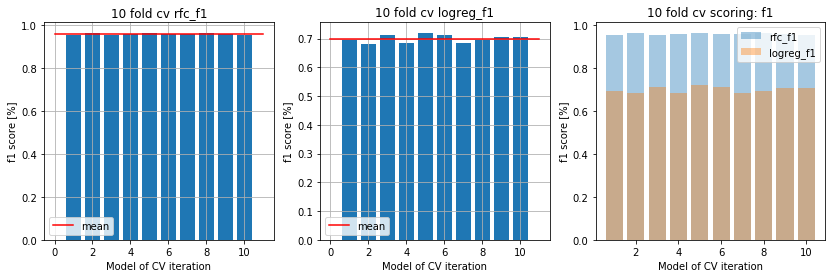

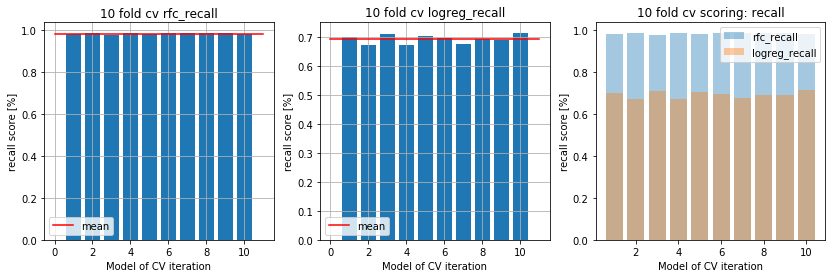

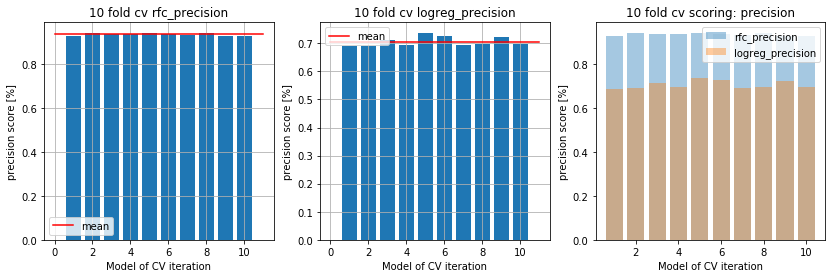

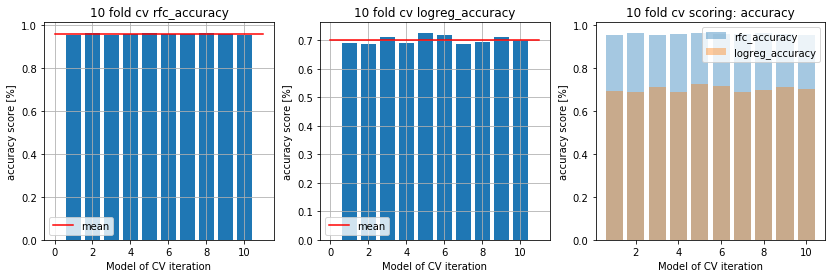

In [38]:
disp_characteristics_subplots(char_benchmark_up[1], ('f1', 'recall', 'precision', 'accuracy'))

> **Observations:**
> - Upsampling the underrepresented class lead to an higher quality of the model of 94% (f1)
> - Additional to that both learning algorithms show much less variance (more stability).
> - In this case the standard random forest classifier seems to have a much higher model quality than the logistic regression

### 4.2.3. Downsampling

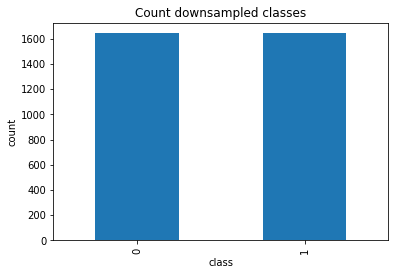

In [39]:
# Downsample overrepresented class
df_c0_down = df_c0_train.sample(cnt_c1_train, random_state=RANDOM_STATE)

# Concat downsampled df and df_c1
df_dsp_tain = shuffle(pd.concat([df_c0_down, df_c1_train]))

# Plot results
ax = df_dsp_tain.exited.value_counts().plot(kind='bar', title='Count downsampled classes');
ax.set_xlabel('class')
ax.set_ylabel('count')
plt.show()

> Both classes contain now around 6200 samples

In [40]:
# Get X,y from upsampled df
X_train_ds = df_dsp_tain.drop('exited', axis=1)
y_train_ds = df_dsp_tain['exited']

In [41]:
# Instancing the machine learning algorithms to check
rfc_ds = RandomForestClassifier(random_state=RANDOM_STATE)
logreg_ds = LogisticRegression(random_state=RANDOM_STATE)
models_ds = {'rfc': rfc_ds, 'logreg': logreg_ds}

# Aggregating the evaluation metrics to compare
comp_metrics = ('f1', 'recall', 'precision', 'accuracy')

# get the characteristc data
with warnings.catch_warnings() as w:
    warnings.filterwarnings("ignore")
    char_benchmark_down = det_characteristic(models_ds, X_train_ds, 
                                          y_train_ds, comp_metrics)

display(create_table(char_benchmark_down[0]))

,std,mean,min,max
rfc_f1,0.025799,0.752335,0.722045,0.788644
logreg_f1,0.027121,0.701776,0.655949,0.741641
rfc_recall,0.029115,0.729302,0.689024,0.768293
logreg_recall,0.037892,0.698252,0.621951,0.745455
rfc_precision,0.026329,0.777202,0.745223,0.822368
logreg_precision,0.022996,0.706125,0.678571,0.748387
rfc_accuracy,0.024465,0.760028,0.732523,0.796353
logreg_accuracy,0.023522,0.703765,0.673780,0.741641


In [42]:
# F1 Score for benchmarking without cv
rfc_standard_ds = RandomForestClassifier(random_state=RANDOM_STATE)
logreg_standard_ds = LogisticRegression(random_state=RANDOM_STATE)

for submodel in (rfc_standard_ds, logreg_standard_ds):
    submodel.fit(X_train_ds, y_train_ds)
    
rfc_standard_ds_pred = rfc_standard_us.predict(X_test)
rfc_standard_ds_f1 = f1_score(y_test, rfc_standard_ds_pred)
logreg_standard_ds_pred = logreg_standard_us.predict(X_test)
logreg_standard_ds_f1 = f1_score(y_test, logreg_standard_ds_pred)

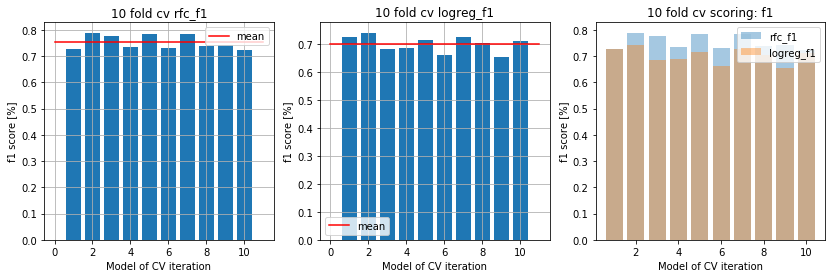

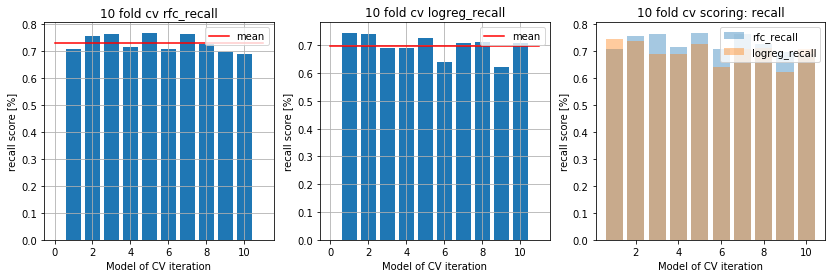

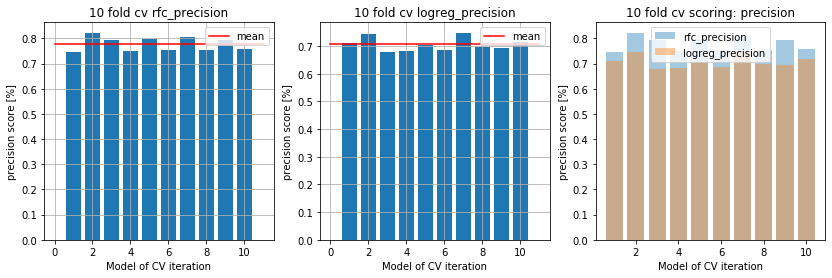

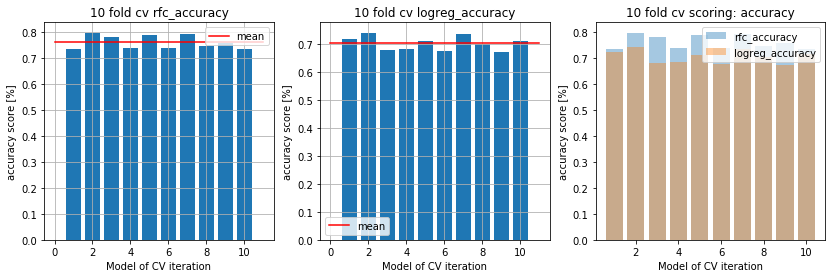

In [43]:
disp_characteristics_subplots(char_benchmark_down[1], ('f1', 'recall', 'precision', 'accuracy'))

> **Observation:**  
> Preformance of standard models nearly equal

### 4.2.3. Class weight adjustments
> In this steps the samplesize was not changed, only the weight for the imbalanced (underrepresented) class has been increased.

In [44]:
# Instancing the machine learning algorithms to check
rfc_weiht = RandomForestClassifier(random_state=RANDOM_STATE,
                                 class_weight='balanced')
logreg_weight = LogisticRegression(random_state=RANDOM_STATE,
                               class_weight='balanced')
models = {'rfc': rfc_weiht, 'logreg': logreg_weight}

# Aggregating the evaluation metrics to compare
comp_metrics = ('f1', 'recall', 'precision', 'accuracy')

# get the characteristc data
with warnings.catch_warnings() as w:
    warnings.filterwarnings("ignore")
    char_benchmark_weight = det_characteristic(models, X_train, 
                                          y_train, comp_metrics)

display(create_table(char_benchmark_weight[0]))

,std,mean,min,max
rfc_f1,0.018809,0.564723,0.530612,0.591440
logreg_f1,0.025449,0.493124,0.453988,0.547414
rfc_recall,0.026978,0.444021,0.396341,0.490909
logreg_recall,0.032070,0.691656,0.648485,0.774390
rfc_precision,0.048455,0.781313,0.702703,0.850000
logreg_precision,0.023283,0.383448,0.341538,0.423333
rfc_accuracy,0.006548,0.859500,0.850000,0.870000
logreg_accuracy,0.020687,0.707375,0.666250,0.737500


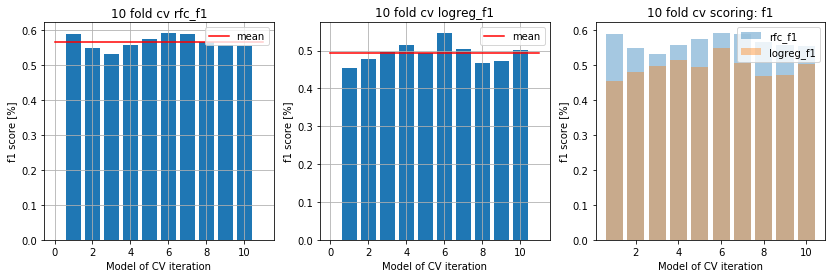

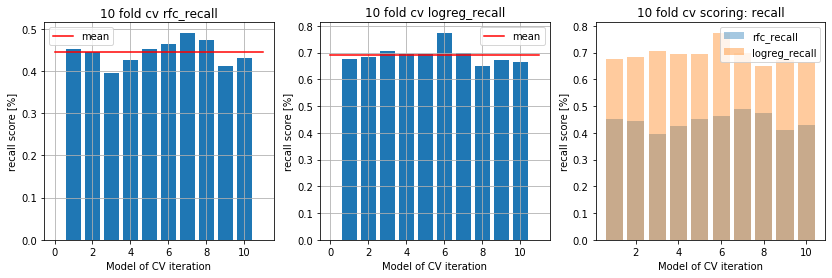

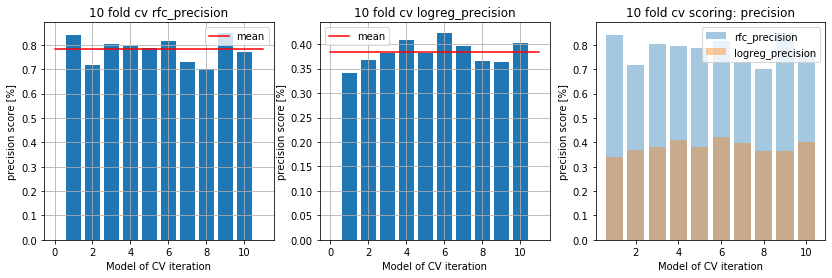

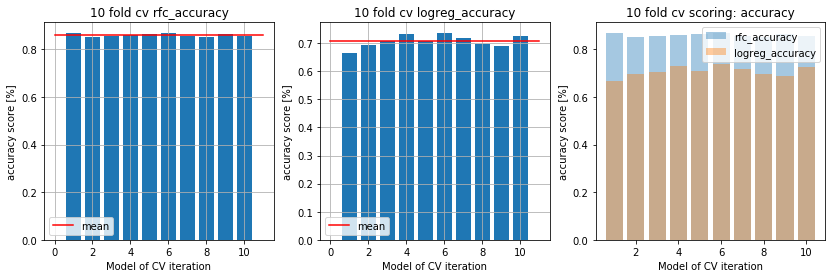

In [45]:
disp_characteristics_subplots(char_benchmark_weight[1], ('f1', 'recall', 'precision', 'accuracy'))

> **Observations:**
> - f1 score of linreg and random forests nearly equal but lower than up/downsampled
> - The variance of the models is higher than in the reference model but lower than in the upsampled df
> - Recall for random forest is super low (38%) whereas the precision wit 75% is fine. 
> -Same applies for the logistic regression but just switched around

### 4.2.4. Standard model comparison
> In this chapter the outcomes of the cv will be compared as well as 3 standard models scores on the testset to have data for benchmarking compared to the tuned ones

In [46]:
def fit_and_eval_logreg_rfc(test, train, eval_metrics, names_eval_metrics):
    '''Trans and evaluates a standard rfc and logreg model with the given data & metrics
    params:
        test: list of test_dfs
        train: list of train_dfs
        eval_metrics: list of eval_funcs
        names_eval_metrics: names of eval_funcs
    
    retuns
        tuple of dicts with the results (rfc, logreg)
    '''
    scores_rfc = {met: [] for met in names_eval_metrics}
    scores_logreg = {met: [] for met in names_eval_metrics}

    # Scoring models on upsampled data
    for (X_tr, y_tr), (X_te, y_te)  in zip(train, test):
        # Instance models
        logreg = LogisticRegression(random_state=RANDOM_STATE)
        rfc = RandomForestClassifier(random_state=RANDOM_STATE)

        # fit models
        for model in (logreg, rfc): 
            model.fit(X_tr, y_tr)    

        # Make predictions
        lpr = logreg.predict(X_te)
        rfcpr = rfc.predict(X_te)

        for idx, score in enumerate(eval_metrics):
            sc_l = score(y_te, lpr)
            sc_rfc = score(y_te, rfcpr)
            scores_logreg[names_eval_metrics[idx]].append(sc_l)
            scores_rfc[names_eval_metrics[idx]].append(sc_rfc)

    return (scores_rfc, scores_logreg)

In [47]:
# Train and evaluate the models
train = [
    [X_train, y_train],
    [X_train_us, y_train_us],
    [X_train_ds, y_train_ds]
]

test = [
    [X_test, y_test],
    [X_test, y_test],
    [X_test, y_test]
]

eval_metrics = [accuracy_score, f1_score, roc_auc_score]
names_eval_metrics = ['acc', 'f1', 'roc_auc']

scores_rfc, scores_logreg = fit_and_eval_logreg_rfc(
    test, train, eval_metrics, names_eval_metrics)

In [48]:
# Checking if models are evaluated correct
scores_logreg

{'acc': [0.8115, 0.717, 0.7215],
 'f1': [0.29532710280373836, 0.4973357015985791, 0.5022341376228776],
 'roc_auc': [0.5809071634753171, 0.715288234837725, 0.719049609611892]}

In [49]:
def compare_scores(data, title):
    '''Plots the data in a grouped bar chart
    parameter:
        data: {str: list(results)}
        title: string of model to score'''
    # set width of bars
    barWidth = 0.25
    plt.figure(figsize=(12,4))

    # Set position of bar on X axis
    r1 = np.arange(len(data))
    r2 = [x + barWidth for x in r1]
    r3 = [x + barWidth for x in r2]
 
    # Make the plot
    for (k,v), r in zip(data.items(), (r1, r2, r3)):
        plt.bar(r, v, width=barWidth, edgecolor='white', label=k)

    # Add xticks on the middle of the group bars
    plt.xlabel('Target balancing', fontweight='bold')
    plt.ylabel('Accuracy')
    plt.xticks([r + barWidth for r in range(len(data))], 
               ['Unbalanced data', 'Upsampled data', 'Downsampled Data'])
 
    # Create legend & Show graphic
    plt.title('Comparison of results for ' + title)
    plt.grid()
    plt.legend()
    plt.show()
    

In [50]:
scores_rfc

{'acc': [0.8675, 0.8555, 0.79],
 'f1': [0.5878693623639192, 0.5923836389280678, 0.5849802371541503],
 'roc_auc': [0.7214785504258563, 0.7341948631226931, 0.7760925087601793]}

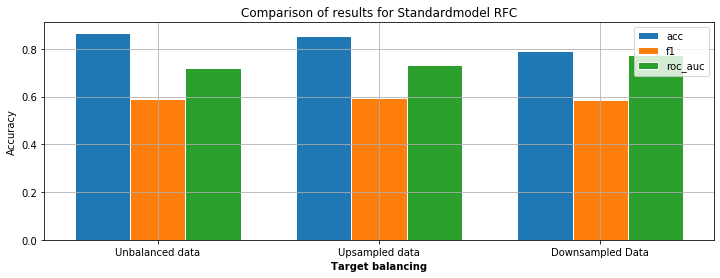

In [51]:
# Plot overview over scores RFC
compare_scores(scores_rfc, 'Standardmodel RFC')

In [52]:
scores_logreg

{'acc': [0.8115, 0.717, 0.7215],
 'f1': [0.29532710280373836, 0.4973357015985791, 0.5022341376228776],
 'roc_auc': [0.5809071634753171, 0.715288234837725, 0.719049609611892]}

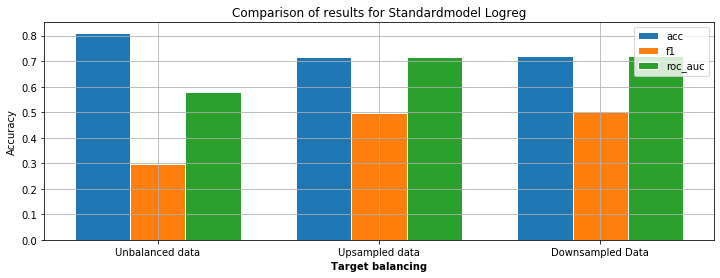

In [53]:
# Plot overview over scores Logreg
compare_scores(scores_logreg, 'Standardmodel Logreg')

> **Observations for the standardmodels (No final evaluation):**
> - The far best scores in cv (f1, rocauc and acc) were archived by random forests
> - For this project Random forest classifier seem to fit better than logistic regression.
> - The hyperparameter need to be tuned because threshold of 59% is not reached yet
> - For further processing the upsampled/downsampled datasets will be used

## 4.2. Training hyperparameter
> Logreg with downsampled data
> RFC with upsampled as well as downsampled data

### 4.2.1. Logistic regression
> Even if logistic regression is not the prefered algorithm of this projects the hyperparams have been trained to test how much the quality acutal can be improved.  
> Thus the following steps have been carried out:
> - Randomized grid search
> - Grid search with cv
> - Threshold adjustment

In [54]:
# Benchmark standard model downsampled
ref_logreg_ds = LogisticRegression(random_state=RANDOM_STATE)
ref_f1_logreg_ds = np.mean(cross_val_score(ref_logreg_ds, X_train_ds, y_train_ds, scoring='f1'))
print('Benchmarking standard model:', ref_f1_logreg_ds)

Benchmarking standard model: 0.7050835779761424


In [55]:
# Benchmark standard model upsampled
ref_logreg_us = LogisticRegression(random_state=RANDOM_STATE)
ref_f1_logreg_us = np.mean(cross_val_score(ref_logreg_us, X_train_us, y_train_us, scoring='f1'))
print('Benchmarking standard model:', ref_f1_logreg_us)

Benchmarking standard model: 0.7003376245052424


#### 4.2.1.1. Randomized grid search
> In this chapter the randomized grid search has been carried out to get a first estimation for the range of good parameters within hyper parameter tuning.   
> The following paramters have been tuned:
> - solver,
> - penalty,
> - c
> - max_iter

In [56]:
# Instance Logreg
logreg_rand_us = LogisticRegression(random_state=RANDOM_STATE)
logreg_rand_ds = LogisticRegression(random_state=RANDOM_STATE)

# Assembling parameter grid for randomized grid search
param_grid_logreg_rand = {
    'solver': ['newton-cg', 'lbfgs', 'liblinear'],
    'penalty': ['l2'],
    'C': [1000, 100, 10, 1.0, 0.1, 0.01],
    'max_iter': [i for i in range(100,6001,100)]
    }

# Instance random search upsampled
logreg_rand_cv_us = RandomizedSearchCV(estimator=logreg_rand_us, 
                                     param_distributions=param_grid_logreg_rand,
                                     n_iter=100,
                                     scoring='f1',
                                     cv=10,
                                     verbose=2,
                                     random_state=RANDOM_STATE,
                                     n_jobs=-1,
                                     return_train_score=True)
# Instance random search downsampled
logreg_rand_cv_ds = RandomizedSearchCV(estimator=logreg_rand_us, 
                                     param_distributions=param_grid_logreg_rand,
                                     n_iter=100,
                                     scoring='f1',
                                     cv=10,
                                     verbose=2,
                                     random_state=RANDOM_STATE,
                                     n_jobs=-1,
                                     return_train_score=True)

logreg_rand_cv_us.fit(X_train_us, y_train_us);
logreg_rand_cv_ds.fit(X_train_ds, y_train_ds);

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Fitting 10 folds for each of 100 candidates, totalling 1000 fits


In [57]:
# Caclulating accuracy of random result upsampled
predict_logreg_rand_us = logreg_rand_cv_us.best_estimator_.predict(X_test)
acc_logreg_rand_us = f1_score(y_test, predict_logreg_rand_us)
print('Benchmarking standard model upsampled:', ref_f1_logreg_us)
print('Best random search model upsampled:', acc_logreg_rand_us)

Benchmarking standard model upsampled: 0.7003376245052424
Best random search model upsampled: 0.5035842293906809


In [58]:
# Caclulating accuracy of random result upsampled
predict_logreg_rand_ds = logreg_rand_cv_ds.best_estimator_.predict(X_test)
acc_logreg_rand_ds = f1_score(y_test, predict_logreg_rand_ds)
print('Benchmarking standard model upsampled:', ref_f1_logreg_ds)
print('Best random search model upsampled:', acc_logreg_rand_ds)

Benchmarking standard model upsampled: 0.7050835779761424
Best random search model upsampled: 0.5045372050816697


> **Observation:**
> - Model quality did improve slightly slightly

#### 4.2.1.2. Grid search with cv
> In this step a gridsearch has been carried out based on the results of the random grid search.  
> Therefore a range of hyperparameters around the determined ones using the random grid search have been choosen.

In [59]:
# Investigating params for defining grid search upsampled
logreg_rand_cv_us.best_estimator_

LogisticRegression(C=0.01, max_iter=5100, random_state=42)

In [60]:
# Investigating params for defining grid search downsampled
logreg_rand_cv_ds.best_estimator_

LogisticRegression(C=0.01, max_iter=5100, random_state=42)

In [61]:
# Init model
logreg_search_us = LogisticRegression(random_state=RANDOM_STATE)
logreg_search_ds = LogisticRegression(random_state=RANDOM_STATE)

# Assemble param grid
param_grid= {
    'solver': ['lbfgs'],
    'penalty': ['l2'],
    'C': [0.001, 0.005, 0.01, 0.015, 0.02],
    'max_iter': [i for i in range(4600,5601,250)]
    }

# define grid search
logreg_search_cv_us = GridSearchCV(estimator=logreg_search_us,
                                param_grid=param_grid,
                                n_jobs=-1,
                                cv=10,
                                scoring='f1',
                                verbose=2,
                                error_score=0)
# define grid search
logreg_search_cv_ds = GridSearchCV(estimator=logreg_search_ds,
                                param_grid=param_grid,
                                n_jobs=-1,
                                cv=10,
                                scoring='f1',
                                verbose=2,
                                error_score=0)

# Train gridsearch
logreg_search_cv_us.fit(X_train_us, y_train_us);
logreg_search_cv_ds.fit(X_train_ds, y_train_ds);

Fitting 10 folds for each of 25 candidates, totalling 250 fits
Fitting 10 folds for each of 25 candidates, totalling 250 fits


In [62]:
# Caclulating accuracy of search result
predict_logreg_search_us = logreg_search_cv_us.best_estimator_.predict(X_test)
acc_logreg_search_us = f1_score(y_test, predict_logreg_search_us)
print(logreg_rand_cv_us.best_estimator_)

print('Best gridsearch f1 score upsampled:', acc_logreg_search_us)
print('Benchmarking standard model upsampled:', ref_f1_logreg_us)

LogisticRegression(C=0.01, max_iter=5100, random_state=42)
Best gridsearch f1 score upsampled: 0.511669658886894
Benchmarking standard model upsampled: 0.7003376245052424


In [63]:
# Caclulating accuracy of search result
predict_logreg_search_ds = logreg_search_cv_ds.best_estimator_.predict(X_test)
acc_logreg_search_ds = f1_score(y_test, predict_logreg_search_ds)
print(logreg_rand_cv_ds.best_estimator_)

print('Best gridsearch f1 score downsampled:', acc_logreg_search_ds)
print('Benchmarking standard model downsampled:', ref_f1_logreg_ds)

LogisticRegression(C=0.01, max_iter=5100, random_state=42)
Best gridsearch f1 score downsampled: 0.5022583559168925
Benchmarking standard model downsampled: 0.7050835779761424


> **Observations:**
> - hyperparam tuning did not increase the model quality slightly for upsampled data
> - hyperparameter tuning decreased model quality slightly for downsampled data
> - Parameter of best model in gridsearch are in the middle so no further iteration needed

#### 4.2.1.3. Threshold adjustments
> In this chapter the influence of the thresholds onto the model quality has been investigated.

##### 4.2.1.3.1. Threshold adjustment upsampled

In [64]:
# Investigate Propabilities
model_th_us = logreg_search_cv_us.best_estimator_
propas_us = model_th_us.predict_proba(X_train)
propas_ones_us = propas_us[:, 1]

In [65]:
for threshold in np.arange(0.3, 0.8, 0.05):
    predicted_valid = propas_ones_us > threshold 
    f1_sco = f1_score(y_train, predicted_valid)
    print('Threshold = {:.2f} | Precision = {:.3f}'.format(threshold, f1_sco))

Threshold = 0.30 | Precision = 0.375
Threshold = 0.35 | Precision = 0.402
Threshold = 0.40 | Precision = 0.441
Threshold = 0.45 | Precision = 0.476
Threshold = 0.50 | Precision = 0.506
Threshold = 0.55 | Precision = 0.497
Threshold = 0.60 | Precision = 0.455
Threshold = 0.65 | Precision = 0.373
Threshold = 0.70 | Precision = 0.273
Threshold = 0.75 | Precision = 0.168


In [66]:
for threshold in np.arange(0.45, 0.55, 0.01):
    predicted_valid = propas_ones_us > threshold 
    f1_sco = f1_score(y_train, predicted_valid)
    print('Threshold = {:.2f} | Precision = {:.3f}'.format(threshold, f1_sco))

Threshold = 0.45 | Precision = 0.476
Threshold = 0.46 | Precision = 0.485
Threshold = 0.47 | Precision = 0.491
Threshold = 0.48 | Precision = 0.493
Threshold = 0.49 | Precision = 0.497
Threshold = 0.50 | Precision = 0.506
Threshold = 0.51 | Precision = 0.505
Threshold = 0.52 | Precision = 0.509
Threshold = 0.53 | Precision = 0.502
Threshold = 0.54 | Precision = 0.501
Threshold = 0.55 | Precision = 0.497


In [67]:
print('Best gridsearch f1 score upsampled:', acc_logreg_search_us)

Best gridsearch f1 score upsampled: 0.511669658886894


> **Observation:**
> - Model quality could be improved around 0.3% with the risk of overfitting and has not been carried out.

In [68]:
# Investigate AUC ROC
model_th_us = logreg_search_cv_us.best_estimator_
propas_us = model_th_us.predict_proba(X_test)
propas_ones_us = propas_us[:, 1]

auc_roc_us = roc_auc_score(y_test, propas_ones_us)
print('ROC - AUC score:', auc_roc_us)

ROC - AUC score: 0.7812464868237086


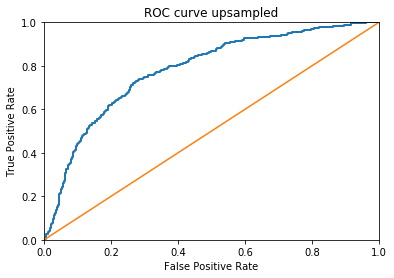

In [69]:
# Plotting curve
fpr, tpr, thresholds = roc_curve(y_test, propas_ones_us) 

plt.figure()
plt.plot(fpr, tpr,linestyle='-',linewidth=2,)

# ROC curve for random model (looks like a straight line)
plt.plot([0, 1], [0, 1], linestyle='-')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve upsampled')

plt.show()

> **Observations:**
> - The model is still a model of good quality because above linear model and auc roc score of 78.12% and above the standard model

##### 4.2.1.3.2. Threshold adjustment downsampled

In [70]:
# Investigate Propabilities
model_th_ds = logreg_search_cv_ds.best_estimator_
propas_ds = model_th_ds.predict_proba(X_train)
propas_ones_ds = propas_ds[:, 1]

In [71]:
for threshold in np.arange(0.3, 0.8, 0.05):
    predicted_valid = propas_ones_ds > threshold 
    f1_sco = f1_score(y_train, predicted_valid)
    print('Threshold = {:.2f} | Precision = {:.3f}'.format(threshold, f1_sco))
    

Threshold = 0.30 | Precision = 0.404
Threshold = 0.35 | Precision = 0.432
Threshold = 0.40 | Precision = 0.463
Threshold = 0.45 | Precision = 0.487
Threshold = 0.50 | Precision = 0.506
Threshold = 0.55 | Precision = 0.506
Threshold = 0.60 | Precision = 0.484
Threshold = 0.65 | Precision = 0.450
Threshold = 0.70 | Precision = 0.398
Threshold = 0.75 | Precision = 0.318


In [72]:
f1_sct_ds = []
for threshold in np.arange(0.5, 0.6, 0.01):
    predicted_valid = propas_ones_ds > threshold 
    f1_sco = f1_score(y_train, predicted_valid)
    print('Threshold = {:.2f} | Precision = {:.3f}'.format(threshold, f1_sco))
    f1_sct_ds.append(f1_sco)

Threshold = 0.50 | Precision = 0.506
Threshold = 0.51 | Precision = 0.512
Threshold = 0.52 | Precision = 0.514
Threshold = 0.53 | Precision = 0.509
Threshold = 0.54 | Precision = 0.506
Threshold = 0.55 | Precision = 0.506
Threshold = 0.56 | Precision = 0.504
Threshold = 0.57 | Precision = 0.504
Threshold = 0.58 | Precision = 0.497
Threshold = 0.59 | Precision = 0.489


In [73]:
print('Best gridsearch f1 score downsampled:', acc_logreg_search_ds)
print('possible improvement:', max(f1_sct_ds) - acc_logreg_search_ds)

Best gridsearch f1 score downsampled: 0.5022583559168925
possible improvement: 0.012147828201167887


> **Observation:**  
> The model qualit could be improved by an other 1.2% with the risk of overfitting to the testset because the threshold adjustment would have been carried out on the testset.  
> Due to the fact that even with that improvement, the best model with 52.2% f1 score would be below the threshold, the adjustment has nott been carried out

In [74]:
# Investigate AUC ROC
model_th_ds = logreg_search_cv_ds.best_estimator_
propas_ds = model_th_ds.predict_proba(X_test)
propas_ones_ds = propas_ds[:, 1]

auc_roc_ds = roc_auc_score(y_test, propas_ones_ds)
print('ROC - AUC score:', auc_roc_ds)

ROC - AUC score: 0.7826145473603874


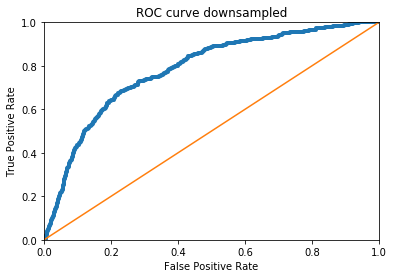

In [75]:
# Plotting curve
fpr, tpr, thresholds = roc_curve(y_test, propas_ones_ds) 

plt.figure()
plt.plot(fpr, tpr,linestyle='-',linewidth=4,)

# ROC curve for random model (looks like a straight line)
plt.plot([0, 1], [0, 1], linestyle='-')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve downsampled')

plt.show()

> **Observation:**
> - Model is still of better quality than the reference model and a Roc Auch score of 78.26%
> - Logistic regression has slightly higer quality with the downsampled training set than with the upsampled dataset.

### 4.2.2. Random Forest
> In this chapter the classification task has been carried out using random forests and both, upsampled and downsampled dataset.  
> Therefore the following steps have been done in order to determine a good set of hyperparameter systematically:
> 1. Generating standard model for benchmarking
> 2. Tuning hyper parameter  
>     2.1. Randomized search (RandomizedSearchCV) for getting first range of good params  
>     2.2. Grid search (GridSearchCV) in the range of results of gird search
> 3. visualizing results(Runtime, accuracy)

In [76]:
# Benchmarking standard model upsampled
ref_rfc_us = RandomForestClassifier(random_state=RANDOM_STATE)
ref_f1_rfc_us = np.mean(cross_val_score(ref_rfc_us, X_train_us, y_train_us, scoring='f1'))
print('Benchmarking standard model upsampled:', ref_f1_rfc_us)

# Benchmarking standard model downsampled
ref_rfc_ds = RandomForestClassifier(random_state=RANDOM_STATE)
ref_f1_rfc_ds = np.mean(cross_val_score(ref_rfc_ds, X_train_ds, y_train_ds, scoring='f1'))
print('Benchmarking standard model downsampled:', ref_f1_rfc_ds)

Benchmarking standard model upsampled: 0.9526125959146304
Benchmarking standard model downsampled: 0.7545421902807641


#### 4.2.2.1. Randomized grid search
> In this chapter the randomized grid search has been carried out to get a first estimation for the range of good parameters within hyper parameter tuning.   

> The following paramters have been tuned:
> - max_features
> - n_estimators
> - max_depth
> - min_sample_split
> - min_sample_leaf

In [77]:
# Aggregating random grid for both rand grid searches
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 1000, num = 10)]
max_features = ['auto', 'sqrt', 'log2']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
criterion = ['gini', 'entropy']

# Create the random grid with selected arguments
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'criterion': criterion,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [78]:
# Instancing and carrying out grid search upsampled /downsampled
rfc_rand_us = RandomForestClassifier(random_state=RANDOM_STATE)
rfc_rand_ds = RandomForestClassifier(random_state=RANDOM_STATE)

rfc_random_us = RandomizedSearchCV(estimator=rfc_rand_us, 
                                 param_distributions=random_grid,
                                 n_iter=100,
                                 scoring='f1',
                                 cv=5,
                                 verbose=2,
                                 random_state=RANDOM_STATE,
                                 n_jobs=-1,
                                 return_train_score=True)

rfc_random_ds = RandomizedSearchCV(estimator=rfc_rand_ds, 
                                 param_distributions=random_grid,
                                 n_iter=100,
                                 scoring='f1',
                                 cv=5,
                                 verbose=2,
                                 random_state=RANDOM_STATE,
                                 n_jobs=-1,
                                 return_train_score=True)

rfc_random_us.fit(X_train_us, y_train_us);
rfc_random_ds.fit(X_train_ds, y_train_ds);

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits


> **Adjust evaluation for us and ds**

In [79]:
print('Best randsearch score on downsampled data:', rfc_random_ds.best_score_)
print('Benchmarking standard model downsampled:', ref_f1_rfc_ds)

Best randsearch score on downsampled data: 0.7643577782400937
Benchmarking standard model downsampled: 0.7545421902807641


In [80]:
print('Best randsearch score on testdata upsampled:', rfc_random_us.best_score_)
print('Benchmarking standard model upsampled:', ref_f1_rfc_us)

Best randsearch score on testdata upsampled: 0.9642122144245917
Benchmarking standard model upsampled: 0.9526125959146304


> **Observation:**
> - The model quality has been improved by around 2% by carrying out the grid search.
> - Tuning the hyperparameter in the are of the found ones will show if the quality could be improved even more.
> - The downsampled model already reaches the quality threshold of 59%

#### 4.2.2.2. Grid search 
> In this step a gridsearch has been carried out based on the results of the random grid search.  
> Therefore a range of hyperparameters around the determined ones using the random grid search have been choosen.

In [81]:
# Investigating best estimator for assembling grid downsampled data
rfc_random_ds.best_estimator_

RandomForestClassifier(max_depth=10, max_features='sqrt', min_samples_leaf=4,
                       min_samples_split=5, n_estimators=120, random_state=42)

In [82]:
# Assembling grid, Elements described in previous chapter
param_grid_search_ds = { 
    'bootstrap': [True],
    'criterion' :['gini'],
    'max_depth' : [35, 37, 40, 42, 45],
    'max_features': ['log2'],
    'min_samples_leaf': [1, 2],
    'min_samples_split' : [11, 10, 12],
    'n_estimators': [540, 560, 580]   
}

In [83]:
# Investigating best estimator for assembling grid upsampled data
rfc_random_us.best_estimator_

RandomForestClassifier(bootstrap=False, max_depth=110, max_features='sqrt',
                       n_estimators=450, random_state=42)

In [84]:
# Assembling grid, Elements described in previous chapter
param_grid_search_us = { 
    'bootstrap': [False],
    'criterion' :['gini'],
    'max_depth' : [100, 110, 120],
    'max_features': ['sqrt'],
    'min_samples_leaf': [1, 2],
    'min_samples_split' : [1, 2, 3],
    'n_estimators': [425, 450, 475]
}

In [85]:
# Instance GridSearchCV for version with criterion
rfc_grid_us = RandomForestClassifier(random_state=RANDOM_STATE)
rfc_grid_ds = RandomForestClassifier(random_state=RANDOM_STATE)

rfc_search_us = GridSearchCV(estimator=rfc_grid_us,
                          param_grid=param_grid_search_us,
                          n_jobs=-1,
                          cv=5,
                          scoring='f1',
                          error_score=0,
                          verbose=2,
                          return_train_score=True)

rfc_search_ds = GridSearchCV(estimator=rfc_grid_ds,
                          param_grid=param_grid_search_ds,
                          n_jobs=-1,
                          cv=5,
                          scoring='f1',
                          error_score=0,
                          verbose=2,
                          return_train_score=True)

rfc_search_us.fit(X_train_us, y_train_us);
rfc_search_ds.fit(X_train_ds, y_train_ds);

Fitting 5 folds for each of 54 candidates, totalling 270 fits
Fitting 5 folds for each of 90 candidates, totalling 450 fits


In [87]:
rfc_search_ds.best_estimator_

RandomForestClassifier(max_depth=35, max_features='log2', min_samples_leaf=2,
                       min_samples_split=12, n_estimators=580, random_state=42)

ROC - AUC score: 0.8642405759788204


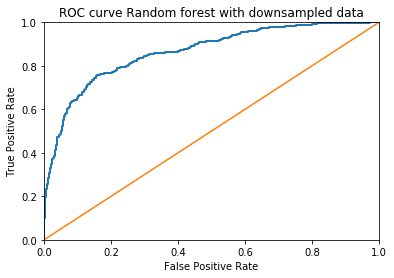

In [88]:
# Check ROC-AUC Curve
propas_test_ds = rfc_random_ds.best_estimator_.predict_proba(X_test)
probabilities_one_test_ds = propas_test_ds[:, 1]
auc_roc_ds = roc_auc_score(y_test, probabilities_one_test_ds)
print('ROC - AUC score:', auc_roc_ds)

# Plotting curve
fpr, tpr, thresholds = roc_curve(y_test, probabilities_one_test_ds) 

plt.figure()
plt.plot(fpr, tpr,linestyle='-',linewidth=2,)

# ROC curve for random model (looks like a straight line)
plt.plot([0, 1], [0, 1], linestyle='-')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve Random forest with downsampled data')

plt.show()

> **Observations:**
> - Model quality at 60.3% on thest data
> - High model quality due to ROC curve and ROC AUC score of 86.36%
> - Gridsearch did not improve the model quality for the testset

In [92]:
rfc_random_us.best_estimator_

RandomForestClassifier(bootstrap=False, max_depth=110, max_features='sqrt',
                       n_estimators=450, random_state=42)

ROC - AUC score: 0.8517847331411083


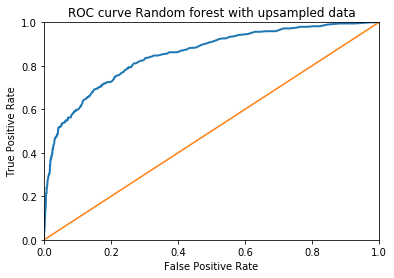

In [93]:
# Check ROC-AUC Curve
propas_test_us = rfc_random_us.best_estimator_.predict_proba(X_test)
probabilities_one_test_us = propas_test_us[:, 1]
auc_roc_us = roc_auc_score(y_test, probabilities_one_test_us)
print('ROC - AUC score:', auc_roc_us)

# Plotting curve
fpr, tpr, thresholds = roc_curve(y_test, probabilities_one_test_us) 

plt.figure()
plt.plot(fpr, tpr,linestyle='-',linewidth=2,)

# ROC curve for random model (looks like a straight line)
plt.plot([0, 1], [0, 1], linestyle='-')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve Random forest with upsampled data')

plt.show()

> **Observations**
> - The model trained with the upsampled data is of  high quality (ROC AUC with 85.17%) and an accuracy of 58.2% but still below the threshold.
> - The training on the downsampled data was better than the one on the upsamled data
> - Gridsearch did not improve the model quality
> - Decision trees perform in this case way better than logistic regression

# 5. Conclution

In [95]:
# Calculation of Benchmark scores
predict_rfc_search_ds = rfc_search_ds.best_estimator_.predict(X_test)
f1_rfc_search_ds = f1_score(y_test, predict_rfc_search_ds)

predict_rfc_rand_us = rfc_random_us.best_estimator_.predict(X_test)
f1_rfc_rand_us = f1_score(y_test, predict_rfc_rand_us)

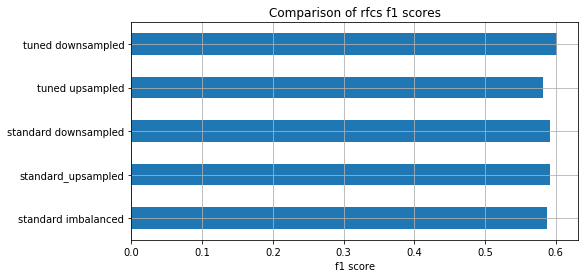

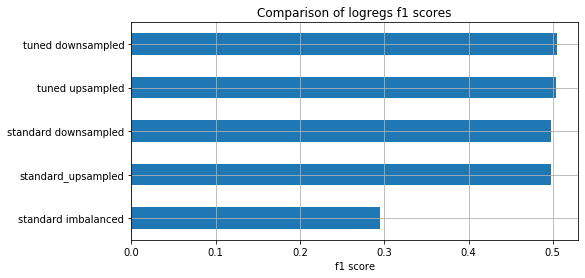

In [96]:
rfc_conc = {
            'standard imbalanced': rfc_standard_imbalanced_f1, 
            'standard_upsampled': rfc_standard_us_f1,
            'standard downsampled': rfc_standard_ds_f1, 
            'tuned upsampled': f1_rfc_rand_us,
            'tuned downsampled': f1_rfc_search_ds
            }

logreg_conc = {
            'standard imbalanced': logreg_standard_imbalanced_f1, 
            'standard_upsampled': logreg_standard_us_f1,
            'standard downsampled': logreg_standard_ds_f1, 
            'tuned upsampled': acc_logreg_rand_us,
            'tuned downsampled': acc_logreg_rand_ds
            }

for tit, conc in zip(('rfcs', 'logregs'), (rfc_conc, logreg_conc)):
    ax = pd.Series(conc).plot(kind='barh', figsize=(8,4))
    ax.grid(True)
    ax.set_title('Comparison of' + ' ' + tit + ' ' +'f1 scores')
    ax.set_xlabel('f1 score')
    plt.show()

- In this project two machine learning algorithms have been trained, a random forest and a logistic regression.
- In final a model with an accuracy of around 61% has been developed by using random forests with the downsampled dataset
- Random forests in general are better for this project (min 55%, logreg 50% tops an.)
- For logistic regression the imbalances of the classes has a higer impact on the f1 score than for random forests (compare standard imbalanced model)
- In order to train the model the following steps have been carried out before: 
    - Preprocessing
        - Filling missing values
        - Replace datatypes and column names
        - Drop unnecessary columns
        - Encode cathegorical features
        - Scale numerical features (Except boolean ones)
        - Investigate outliers and check if they need to be dropped or not  
        - -> Talk to the data engineer if the 0 entries are legit or not
    - Splitting the data
    - Evaluate general expected performance of machine learning algorithms for this project by cross validation
- Tuning the hyperparamerters increased the model accuracy of 2-3%